In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from rfest import splineLG, splineLNP
from rfest.utils import get_n_samples, uvec, split_data, build_design_matrix
from rfest.simulate import gaussian2d, noise2d, get_response
from rfest.metrics import mse

from tqdm import tqdm, tnrange, tqdm_notebook



In [2]:
from rfest.priors import smoothness_kernel
from rfest.splines import build_spline_matrix
from rfest import ASD

In [3]:
def STA(X, y, C=None):
    k = X.T @ y     
    return k    

def MLE(X, y, C=None):
    k = np.linalg.inv(X.T @ X) @ X.T @ y     
    return k

def MAP(X, y, C):
    k = np.linalg.inv(X.T @ X + np.linalg.inv(C)) @ X.T @ y    
    return k

def SPL_MLE(XS, y, C=None):
    k = S @ np.linalg.inv(XS.T @ XS) @ XS.T @ y
    return k

In [4]:
scale_factors = np.array([0.5, 1, 2, 4, 8, 16, 32, 64])


def get_time(X_all, y_all, n_feature, method, C=None, S=None, 
             num_trials=10, scale_factors=None):

    all_time_lapse_mean = []
    all_time_lapse_std = []    

    n_samples_list = (n_features * scale_factors).astype(int)
    for ii in tnrange(len(scale_factors)):

        time_lapse = []

        for jj in range(num_trials):   
#         for jj in range(num_trials):

            X = X_all[:n_samples_list[ii]]
            y = y_all[:n_samples_list[ii]]
            
            if S is not None:
                X = X @ S

            start = time.time()
            k = method(X, y, C)      
            time_lapse.append(time.time() - start)

        all_time_lapse_mean.append(np.mean(time_lapse))
        all_time_lapse_std.append(np.std(time_lapse))
        
    return np.array(all_time_lapse_mean), np.array(all_time_lapse_std)

In [5]:
from rfest.utils import get_n_samples

/Users/ziweih/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  # This is added back by InteractiveShellApp.init_path()


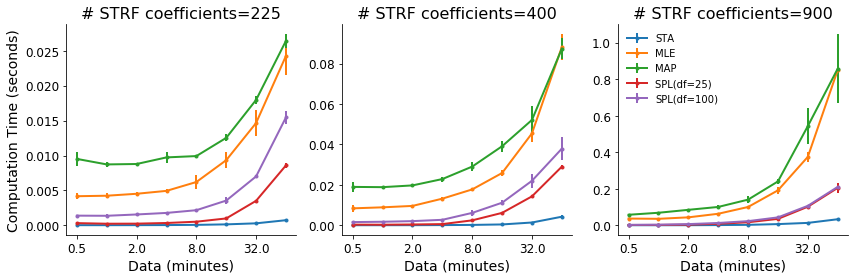

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))
n_features_all = []
xaxis = np.arange(len(scale_factors))

dimss = [[15, 15], [20, 20], [30, 30]]
stds = [[2,2], [4,4], [8,8]]
xlabel = [0.,  0.5, 2.,  8., 32., 64.]

dt = 0.033
n_samples = get_n_samples(64, dt)

    
for xx in range(3):
    
    w_true = gaussian2d(dims=dimss[xx], std=stds[xx])

    dims = w_true.shape
    dt = 0.033

    dims = w_true.shape
    n_features = np.prod(dims)
    n_features_all.append(n_features)
    
    X_all = noise2d(n_samples=n_samples, dims=dims, design_matrix=True, random_seed=2046)
    X_all = X_all.reshape(n_samples, n_features)
    y_all = get_response(X_all, w_true.flatten(), dt=dt)
    
    
    m_sta, s_sta = get_time(X_all, y_all, n_feature=n_features, method=STA, scale_factors=scale_factors)
    m_mle, s_mle = get_time(X_all, y_all, n_feature=n_features, method=MLE, scale_factors=scale_factors)

    asd = ASD(X_all, y_all, dims=dims)
    p0 = [1., 1., 2., 2.,]
    C, _ = asd.update_C_prior(p0)
    m_map, s_map = get_time(X_all, y_all, n_feature=n_features, method=MAP, C=C, scale_factors=scale_factors)

    df = [5,5]
    S = build_spline_matrix(dims=dims, df=df, smooth='cr')
        
    m_spl_25, s_spl_25  = get_time(X_all, y_all, n_feature=n_features, method=SPL_MLE, C=None, S=S, 
                                   num_trials=10, scale_factors=scale_factors)

    df = [10,10]
    S = build_spline_matrix(dims=dims, df=df, smooth='cr')
    m_spl_100, s_spl_100  = get_time(X_all, y_all, n_feature=n_features, method=SPL_MLE, C=None, S=S, 
                                     num_trials=10, scale_factors=scale_factors)


    ax[xx].errorbar(xaxis, m_sta, s_sta, marker='.', capsize=0, lw=2, label='STA')
    ax[xx].errorbar(xaxis, m_mle, s_mle, marker='.', capsize=0, lw=2, label='MLE')
    ax[xx].errorbar(xaxis, m_map, s_map, marker='.', capsize=0, lw=2, label='MAP')
    ax[xx].errorbar(xaxis, m_spl_25, s_spl_25, marker='.', capsize=0, lw=2, label='SPL(df=25) ')
    ax[xx].errorbar(xaxis, m_spl_100, s_spl_100, marker='.', capsize=0, lw=2, label='SPL(df=100)')

#     ax[xx].set_ylim(0, 0.5)
    ax[xx].set_xticklabels(xlabel)
    ax[xx].tick_params(axis='both', labelsize=12)
    ax[xx].spines['right'].set_visible(False)
    ax[xx].spines['top'].set_visible(False)
    if xx == 2:
        ax[xx].legend(frameon=False)
    ax[xx].set_xlabel('Data (minutes)', fontsize=14)
    if xx == 0:
        ax[xx].set_ylabel('Computation Time (seconds)', fontsize=14)
    ax[xx].set_title(f'# STRF coefficients={n_features}', fontsize=16)
    
    
fig.tight_layout()
fig.savefig('figs/Figure_time_new.pdf')
# import seaborn as sns
# sns.despine(offset=0, trim=True)